*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)


* [Partie 3 🛠 Machine Learning (Régression) ](#Partie_2)

    * [3.1 Régression lineaire comme baseline](#Section_2.1)
    * [3.2 Régression linéaire sur données centrées réduite](#Section_2.2)
    * [3.3 Régression Ridge ](#Section_2.3)
    * [3.4 Régression LASSO ](#Section_2.4)
    * [3.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [3.6 Régression linéaire sur données en log ](#Section_2.6)
    * [3.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [3.8 XGBoost](#Section_2.8)
    * [3.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 sets
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour remplacer les données manquantes
from sklearn.impute import KNNImputer

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

## Présentation partie 3
<a class="anchor" id="Partie_2"></a>

Cette étude a pour objectif de présenter les différentes méthodes de régression linéaire des librairies
Scikit learn et la très populaire XGBoost.
Il s'agit d'expliquer la variable "TotalGHGEmissions"


In [2]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [3]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [4]:
target = df[["TotalGHGEmissions"]]

### Création de fonctions

In [5]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [6]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [7]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

In [8]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [9]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.3706607673464545 
 R2 sur le set de test:  0.07289011271743029


In [10]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

729.2671398843478


In [11]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,7.34,56340,36.377167,-29.037167
1,4.67,30796,-44.802920,49.472920
2,3.41,23177,-56.253766,59.663766
3,8.61,25000,45.333572,-36.723572
4,37.31,20539,7.009464,30.300536
...,...,...,...,...
1000,9.68,55842,52.260633,-42.580633
1001,163.19,526423,941.209737,-778.019737
1002,138.03,40329,36.872122,101.157878
1003,136.07,220018,136.991890,-0.921890


<Figure size 300x300 with 0 Axes>

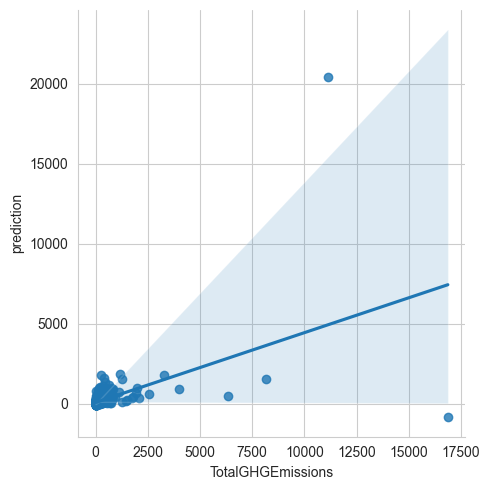

In [12]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [13]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
tx_gaz,159.445841,159.445841
NumberofBuildings,72.429738,72.429738
NumberofFloors,-11.558224,11.558224
BulType,5.112737,5.112737
Council,-3.344004,3.344004
PPT,-3.197619,3.197619
Zip,-0.966427,0.966427
years,0.384541,0.384541
Voisin,-0.059849,0.059849
ThirdLargestPropertyUseTypeGFA,-0.006669,0.006669


Text(0.5, 1.0, 'Coefficients de regression')

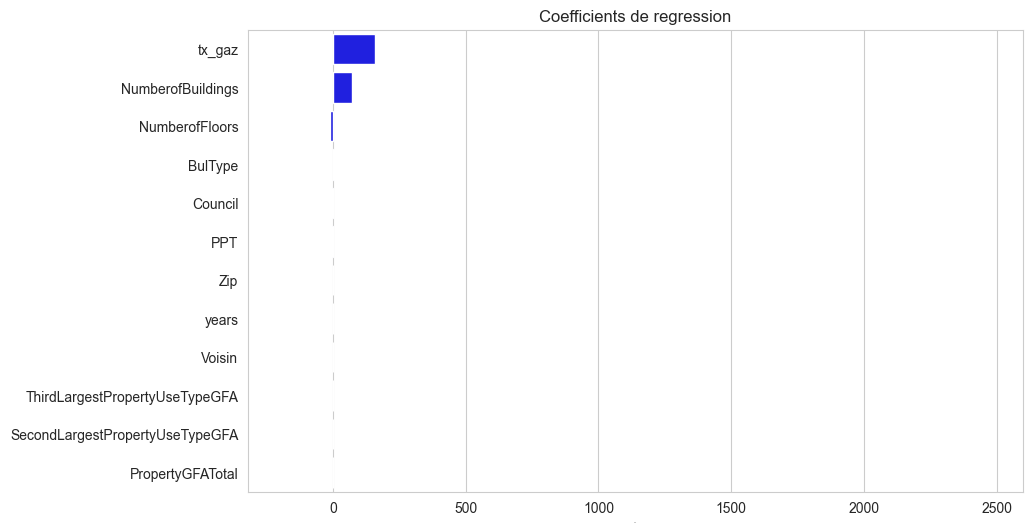

In [14]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320, 2_600)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [15]:
# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["TotalGHGEmissions"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [16]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.3706607673464547 
 R2 sur le set de test:  0.07289011271832635


In [17]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.350153857920304


In [18]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred


,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.155058,-0.053759
1,-0.213760,-0.292659,-0.305353,0.091593
2,-0.216093,-0.327532,-0.326553,0.110461
3,-0.206466,-0.319188,-0.138476,-0.067989
4,-0.153331,-0.339606,-0.209429,0.056098
...,...,...,...,...
1000,-0.204485,-0.178019,-0.125651,-0.078833
1001,0.079721,1.975903,1.520135,-1.440414
1002,0.033141,-0.249025,-0.154141,0.187282
1003,0.029512,0.573440,0.031219,-0.001707


<Figure size 300x300 with 0 Axes>

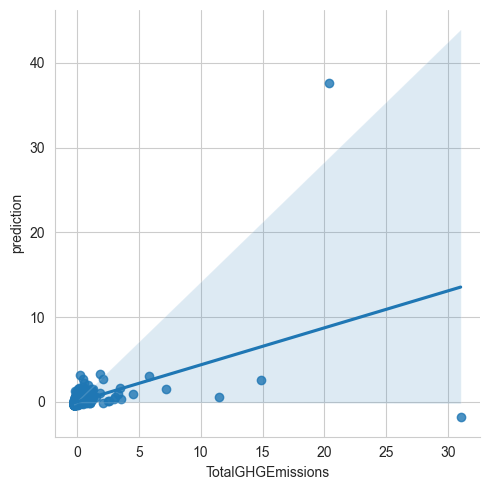

In [19]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [20]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.544039,0.544039
NumberofBuildings,0.283483,0.283483
SecondLargestPropertyUseTypeGFA,0.170908,0.170908
ThirdLargestPropertyUseTypeGFA,-0.162403,0.162403
NumberofFloors,-0.117938,0.117938
tx_gaz,0.079730,0.079730
PPT,-0.034513,0.034513
years,0.023592,0.023592
Zip,-0.017997,0.017997
Council,-0.013130,0.013130


Text(0.5, 1.0, 'Coefficients de regression')

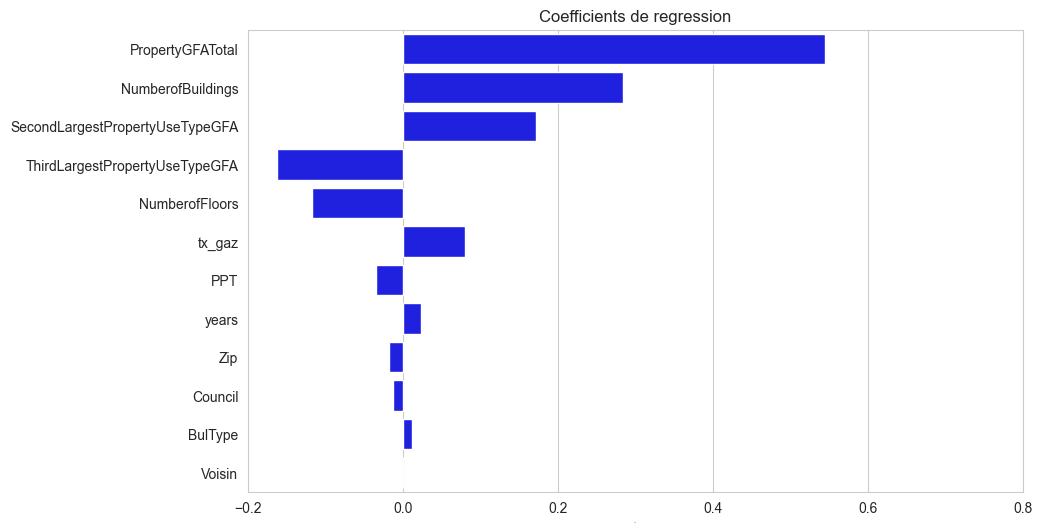

In [21]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [22]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [23]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"s")

Temps de calcul :  0.6776895523071289 s


In [24]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [25]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = -0.257 (+/-1.281) for {'alpha': 0.2}
mean_test_score = -0.256 (+/-1.280) for {'alpha': 0.4}
mean_test_score = -0.256 (+/-1.279) for {'alpha': 0.6}
mean_test_score = -0.255 (+/-1.279) for {'alpha': 0.8}
mean_test_score = -0.255 (+/-1.278) for {'alpha': 0.9}
mean_test_score = -0.253 (+/-1.273) for {'alpha': 2}
mean_test_score = -0.247 (+/-1.259) for {'alpha': 5}
mean_test_score = -0.239 (+/-1.241) for {'alpha': 9}
mean_test_score = -0.237 (+/-1.237) for {'alpha': 10}
mean_test_score = -0.235 (+/-1.233) for {'alpha': 11}
mean_test_score = -0.233 (+/-1.228) for {'alpha': 12}
mean_test_score = -0.167 (+/-1.081) for {'alpha': 50}
mean_test_score = -0.100 (+/-0.930) for {'alpha': 100}


In [26]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [27]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [28]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.543772,0.543772
NumberofBuildings,0.283436,0.283436
SecondLargestPropertyUseTypeGFA,0.170983,0.170983
ThirdLargestPropertyUseTypeGFA,-0.162338,0.162338
NumberofFloors,-0.117865,0.117865
tx_gaz,0.079727,0.079727
PPT,-0.034507,0.034507
years,0.023583,0.023583
Zip,-0.017993,0.017993
Council,-0.013131,0.013131


Text(0.5, 1.0, 'Coefficients de regression')

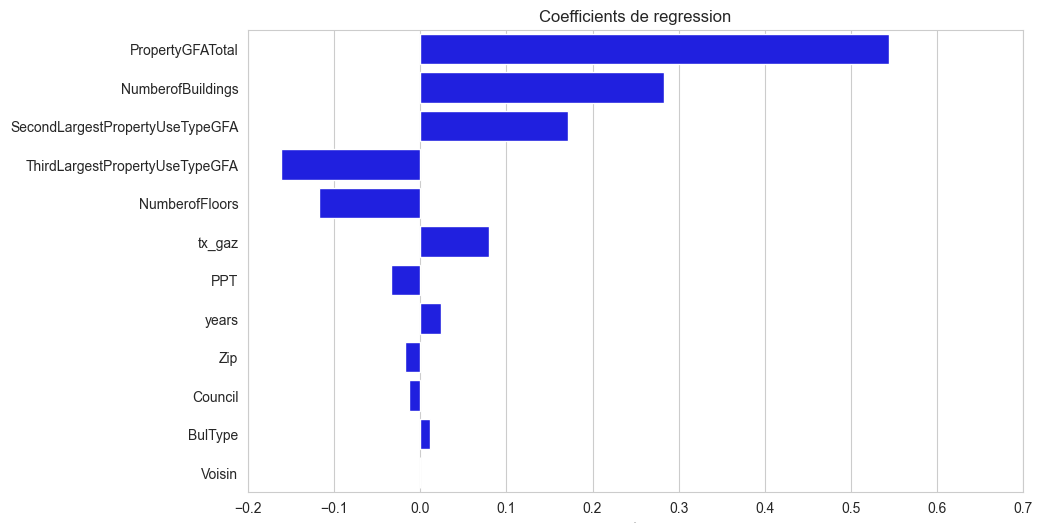

In [29]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,0.7)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [30]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.366780136909426 
 R2 sur le set de test:  0.18807898796249256


In [31]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.2634979621006437


In [32]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.166367,-0.042450
1,-0.213760,-0.292659,-0.284406,0.070646
2,-0.216093,-0.327532,-0.311894,0.095802
3,-0.206466,-0.319188,-0.129908,-0.076557
4,-0.153331,-0.339606,-0.179690,0.026359
...,...,...,...,...
1000,-0.204485,-0.178019,-0.127508,-0.076977
1001,0.079721,1.975903,1.470261,-1.390539
1002,0.033141,-0.249025,-0.127180,0.160321
1003,0.029512,0.573440,0.076841,-0.047329


<Figure size 300x300 with 0 Axes>

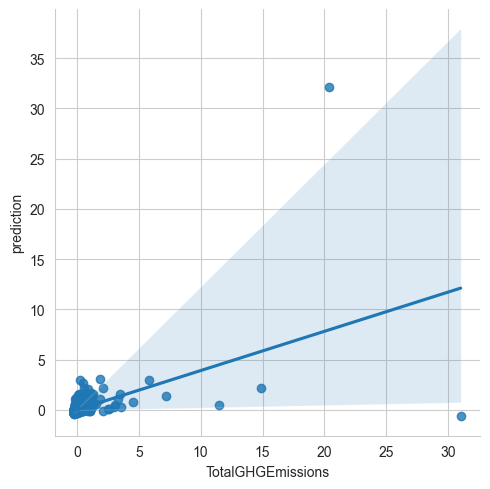

In [33]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [34]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [35]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"s")

Temps de calcul :  0.7983348369598389 s


In [36]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [37]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.167 (+/-0.316) pour {'alpha': 0.1}
mean_test_score = 0.085 (+/-0.200) pour {'alpha': 0.2}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.4}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.6}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.8}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 0.9}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 2}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 5}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 9}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 10}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 11}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 12}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 50}
mean_test_score = -0.016 (+/-0.050) pour {'alpha': 100}


In [38]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [39]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.199084438839361


In [40]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.24652299782042164 
 R2 sur le set de test:  0.2687527881901348


In [41]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [42]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.101890,-0.106927
1,-0.213760,-0.292659,-0.130344,-0.083416
2,-0.216093,-0.327532,-0.138831,-0.077261
3,-0.206466,-0.319188,-0.133744,-0.072721
4,-0.153331,-0.339606,-0.125681,-0.027650
...,...,...,...,...
1000,-0.204485,-0.178019,-0.062467,-0.142018
1001,0.079721,1.975903,0.979366,-0.899645
1002,0.033141,-0.249025,-0.113209,0.146350
1003,0.029512,0.573440,0.219780,-0.190268


<Figure size 300x300 with 0 Axes>

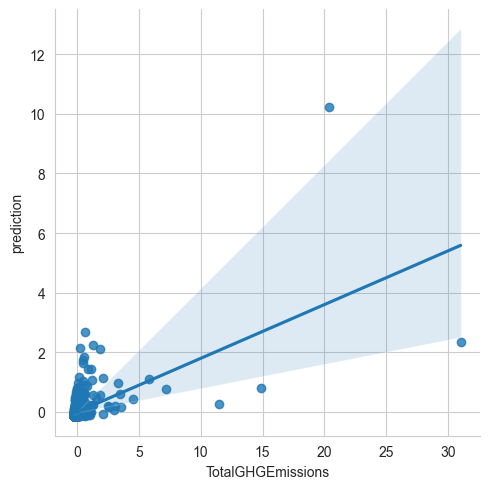

In [43]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [44]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
SecondLargestPropertyUseTypeGFA,0.142652,0.142652
PropertyGFATotal,0.007477,0.007477
years,-0.000000,0.000000
NumberofFloors,0.000000,0.000000
NumberofBuildings,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
tx_gaz,0.000000,0.000000
BulType,0.000000,0.000000
PPT,-0.000000,0.000000
Zip,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

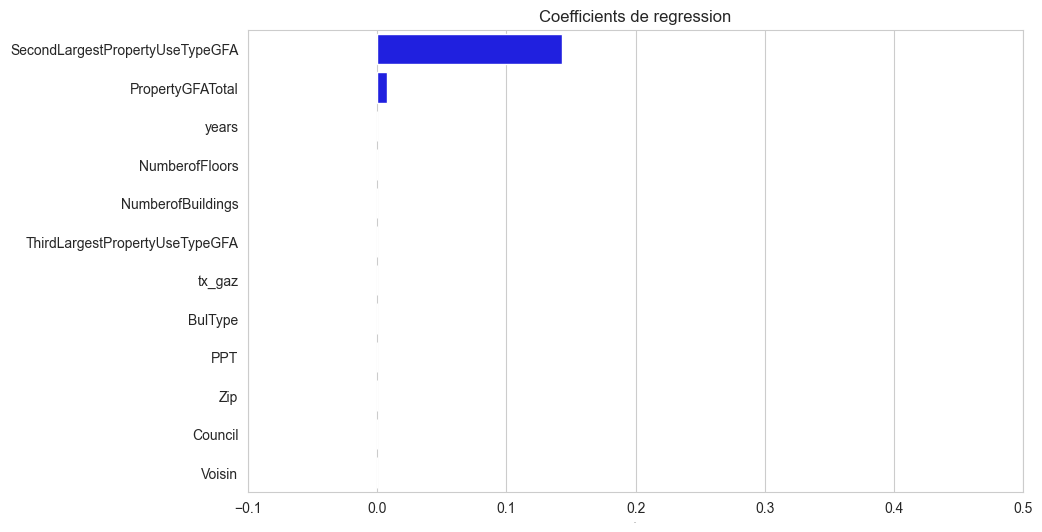

In [45]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.1, 0.5)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [46]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.24635918103713794, 0.37022269822413467, 0.40676701411641825, 0.1870570148607783, 0.23513832117378386, 0.22582189559127963, 0.16874855922418064, 0.16138751591158218, 0.17021464736241843, 0.1527275335195536, 0.12715060277411283] 
 [0.21118622932969425, 0.3409776531607265, 0.46440312351235746, 0.5742476770572945, 0.6577149120892278, 0.7291142437827989, 0.7942982444847954, 0.8582309556669614, 0.9114521444818886, 0.9592213144274018, 0.9903288559495477]


In [47]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [48]:
pca.explained_variance_ratio_.sum()

0.46440312351235735

In [49]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [50]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [51]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.2622300936052224 
 R2 sur le set de test:  0.4067670141164178


In [52]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.080016277559916


In [53]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,-0.208817,-0.175740,-0.249408,0.040591
1,-0.213760,-0.292659,-0.128751,-0.085009
2,-0.216093,-0.327532,-0.305403,0.089310
3,-0.206466,-0.319188,0.027689,-0.234155
4,-0.153331,-0.339606,-0.124987,-0.028344
...,...,...,...,...
1000,-0.204485,-0.178019,-0.171888,-0.032596
1001,0.079721,1.975903,1.145808,-1.066087
1002,0.033141,-0.249025,-0.165161,0.198302
1003,0.029512,0.573440,0.108092,-0.078580


<Figure size 300x300 with 0 Axes>

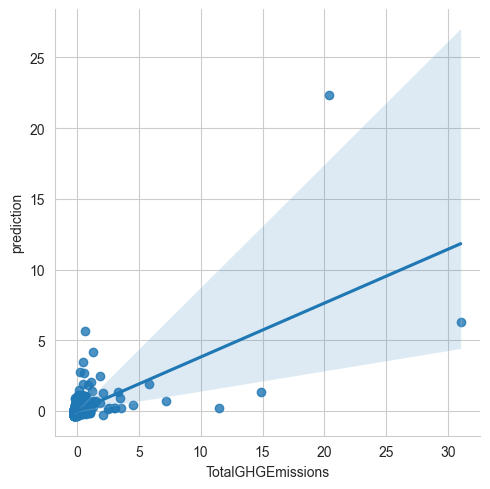

In [54]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [55]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.270003,0.270003
comp_2,0.242505,0.242505
comp_3,0.166267,0.166267


Text(0.5, 1.0, 'Coefficients de regression')

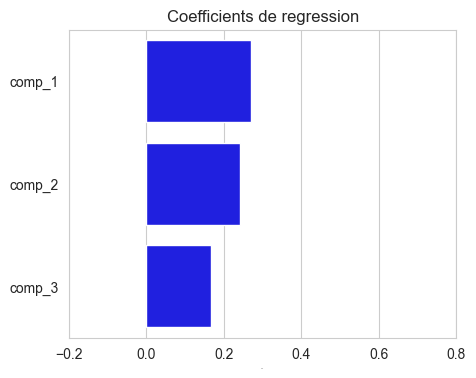

In [56]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [57]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float["ENERGYSTARScore"]=df['ENERGYSTARScore']
df_float_log = df_au_log(df_float)
df_energy=df_float_log[["ENERGYSTARScore"]]
df_float_log=df_float_log.drop(columns=["ENERGYSTARScore"])

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1134612248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_13576\1232816784.py:4: RuntimeWarning: invalid value encountered in log
  val = np.log(data_1.values)


In [58]:
df_tot= pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log=df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [59]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.015619039535522461 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [60]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.442143523485123 
 R2 sur le set de test:  0.4600707748583075


In [61]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

1.1261092451836854


In [62]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,3.428715,2.026735
1,3.586016,12.333731,4.732339,-1.146323
2,3.015045,11.701072,4.014994,-0.999950
3,1.733424,10.108386,2.524700,-0.791276
4,6.122975,12.843821,5.892258,0.230717
...,...,...,...,...
1000,1.423108,9.966603,2.273116,-0.850008
1001,4.927471,10.604826,2.873139,2.054332
1002,2.458734,9.961756,2.331701,0.127033
1003,4.083284,10.933107,3.840295,0.242988


<Figure size 300x300 with 0 Axes>

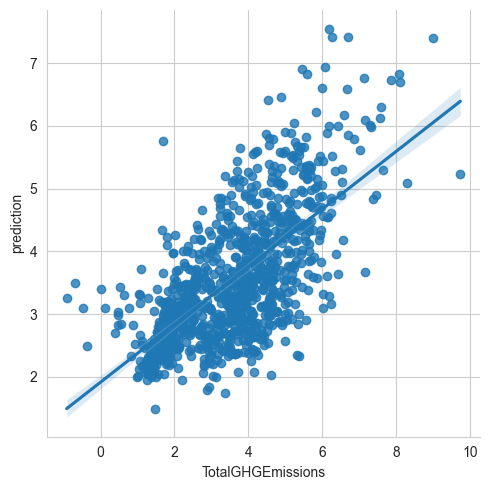

In [63]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [64]:
coef = pd.DataFrame(data=model_log.coef_,columns=df_float_log.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,1.100935,1.100935
BulType,0.543120,0.543120
NumberofBuildings,0.257770,0.257770
PPT,-0.191132,0.191132
Zip,-0.159046,0.159046
years,0.154595,0.154595
NumberofFloors,-0.139870,0.139870
tx_gaz,-0.098413,0.098413
Voisin,-0.088321,0.088321
Council,0.050670,0.050670


Text(0.5, 1.0, 'Coefficients de regression')

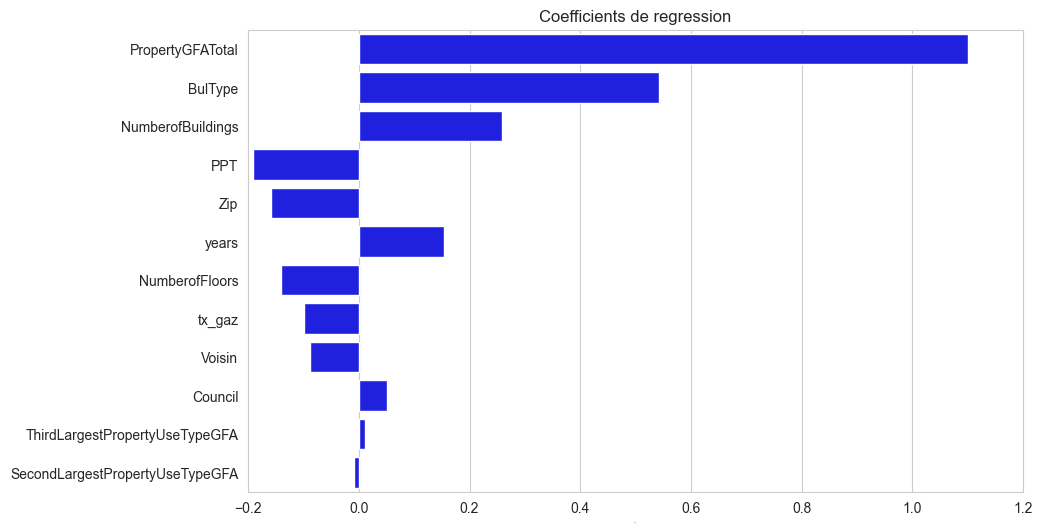

In [65]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [66]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [67]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  119.29461574554443 ms


In [68]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.764 (+/-0.028) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.032) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.816 (+/-0.033) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.793 (+/-0.032) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.815 (+/-0.035) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.825 (+/-0.040) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.807 (+/-0.048) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.816 (+/-0.051) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.817 (+/-0.050) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.764 (+/-0.028) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.798 (+/-0.032) for {'alpha': 0.5, 'ma

In [69]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [70]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [71]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8975603145760844 
 R2 sur le set de test:  0.842087176490947


In [72]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6197296967137013


In [73]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,4.021004,1.434445
1,3.586016,12.333731,4.144967,-0.558951
2,3.015045,11.701072,2.868453,0.146592
3,1.733424,10.108386,1.417019,0.316405
4,6.122975,12.843821,5.653824,0.469151
...,...,...,...,...
665,4.601062,11.986548,4.988213,-0.387151
666,3.193763,11.041016,3.024809,0.168954
667,1.488400,10.442026,1.790435,-0.302035
668,3.408504,10.281444,4.338785,-0.930281


<Figure size 300x300 with 0 Axes>

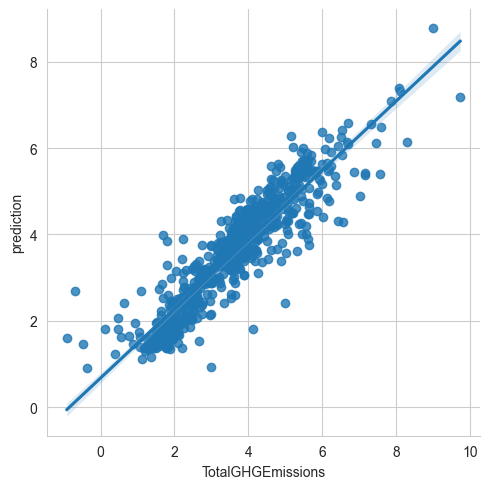

In [74]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

In [75]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float_log.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
tx_gaz,0.512121,0.512121
PropertyGFATotal,0.357494,0.357494
PPT,0.045216,0.045216
BulType,0.026314,0.026314
years,0.014130,0.014130
NumberofFloors,0.012749,0.012749
Zip,0.008135,0.008135
ThirdLargestPropertyUseTypeGFA,0.007435,0.007435
SecondLargestPropertyUseTypeGFA,0.005982,0.005982
NumberofBuildings,0.005702,0.005702


Text(0.5, 1.0, 'Coefficients de regression')

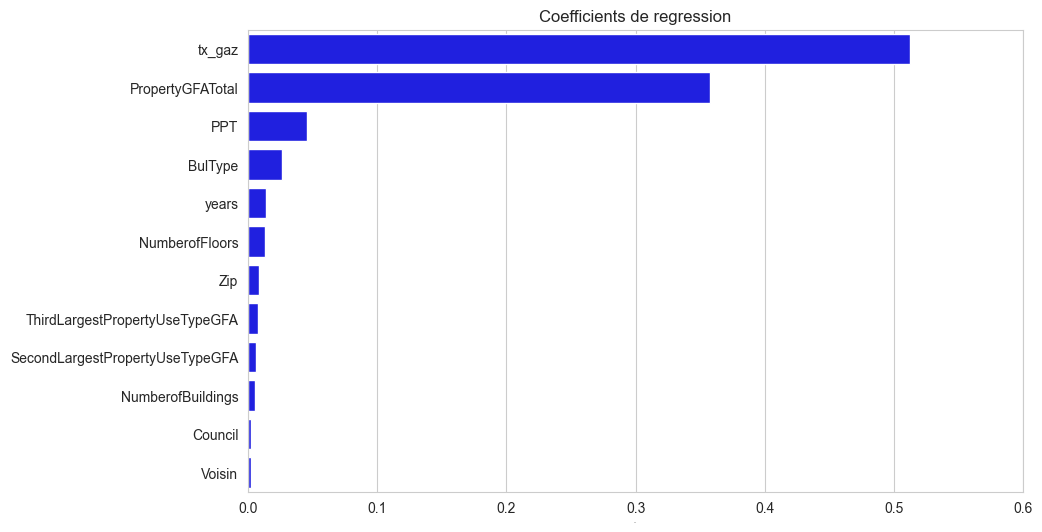

In [76]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 0.6)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [77]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [78]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  9.615933656692505 s


In [79]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.756 (+/-0.030) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.781 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.782 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.794 (+/-0.028) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.808 (+/-0.035) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.806 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [80]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [81]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9114605354248406 
 R2 sur le set de test:  0.8350601103080209


In [82]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[17:33:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

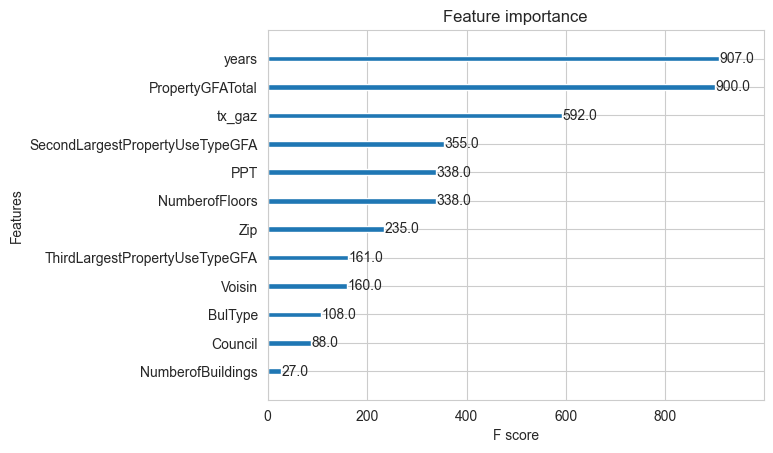

In [83]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [84]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.680246291096147


In [85]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,3.791996,1.663454
1,3.586016,12.333731,4.291311,-0.705295
2,3.015045,11.701072,2.652241,0.362804
3,1.733424,10.108386,1.572123,0.161301
4,6.122975,12.843821,5.581564,0.541411
...,...,...,...,...
665,4.601062,11.986548,5.004911,-0.403850
666,3.193763,11.041016,2.743612,0.450152
667,1.488400,10.442026,1.680712,-0.192313
668,3.408504,10.281444,4.237140,-0.828636


<Figure size 300x300 with 0 Axes>

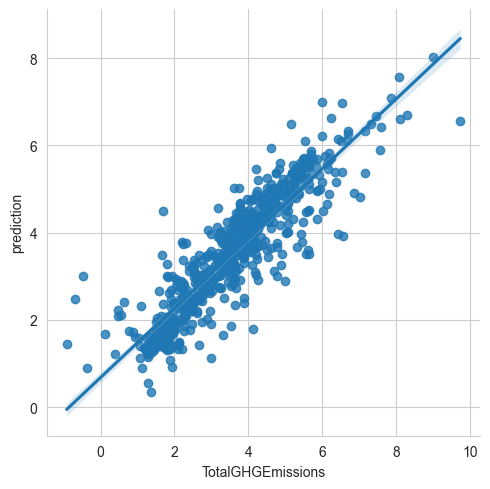

In [86]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="TotalGHGEmissions", y="prediction")

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [87]:
# On inclut la variable ENERGYscore ds le modèle
df_float_log = pd.concat([df_float_log,df_energy],axis=1)

In [88]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [89]:
# Suppression des dernières données manquantes

df_tot = pd.concat([df_float_log,target_log],axis=1)
df_tot=df_tot.dropna(axis=0,subset="TotalGHGEmissions")
target_log = df_tot[["TotalGHGEmissions"]]
df_float_log = df_tot.drop(columns=["TotalGHGEmissions"])

In [90]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [91]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  13.576199054718018 ms


In [92]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.706 (+/-0.028) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.738 (+/-0.036) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.738 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.753 (+/-0.034) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.769 (+/-0.043) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.765 (+/-0.054) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [93]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [94]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[17:33:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

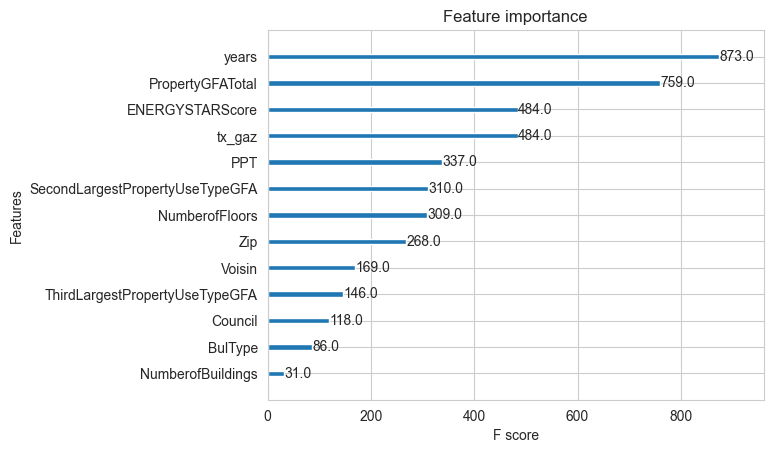

In [95]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [96]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.900966311020293 
 R2 sur le set de test:  0.7944651063880024


In [97]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.706742105222043


In [98]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["TotalGHGEmissions","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["TotalGHGEmissions"]-pred["prediction"]
pred

,TotalGHGEmissions,PropertyGFATotal,prediction,residus
0,5.455449,10.632629,4.669371,0.786078
1,3.586016,12.333731,3.435290,0.150725
2,3.015045,11.701072,3.047729,-0.032685
3,1.733424,10.108386,1.445767,0.287657
4,6.122975,12.843821,5.249951,0.873024
...,...,...,...,...
665,4.601062,11.986548,4.602853,-0.001791
666,3.193763,10.819178,3.242096,-0.048333
667,1.488400,10.442026,1.881143,-0.392743
668,3.408504,10.281444,3.747211,-0.338707


<AxesSubplot: xlabel='TotalGHGEmissions', ylabel='prediction'>

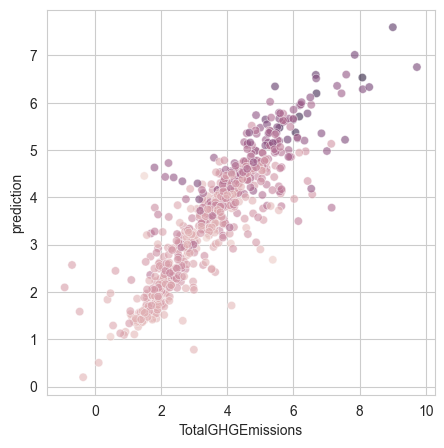

In [99]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="TotalGHGEmissions", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)